In [1]:
import gc
import logging
import os
import glob
import pandas as pd

import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')


import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from math import exp

import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

num = 10

/home/vikrant/core/home/R/goal/baselines/deep_prediction/argoverse-api/argoverse/map_representation/map_api.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lane_polygons = np.array(self.get_vector_map_lane_polygons(city_name))
/home/vikrant/core/home/R/goal/baselines/deep_prediction/argoverse-api/argoverse/map_representation/map_api.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  driveable_areas = np.array(self.get_vector_map_driveable_areas(city_name))


In [6]:
path = "/home/vikrant/datasets/datasets/argoverse/forecasting_sample/data/"
dfs = [pd.read_csv(file) for file in  glob.glob(os.path.join(path, "*.csv"))]

In [7]:
df = dfs[0]
agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
av_df = df[df['OBJECT_TYPE'] == 'AV']
agent_df['X'].values
df

,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME
0,3.159714e+08,00000000-0000-0000-0000-000000000000,AV,1830.150005,433.317321,PIT
1,3.159714e+08,00000000-0000-0000-0000-000000042390,OTHERS,1897.242229,493.092451,PIT
2,3.159714e+08,00000000-0000-0000-0000-000000043093,OTHERS,1809.351506,416.446528,PIT
3,3.159714e+08,00000000-0000-0000-0000-000000042732,AGENT,1812.856823,419.325983,PIT
4,3.159714e+08,00000000-0000-0000-0000-000000000000,AV,1831.016307,434.046087,PIT
...,...,...,...,...,...,...
175,3.159714e+08,00000000-0000-0000-0000-000000042732,AGENT,1863.142830,465.076151,PIT
176,3.159714e+08,00000000-0000-0000-0000-000000043144,OTHERS,1954.945024,541.463684,PIT
177,3.159714e+08,00000000-0000-0000-0000-000000000000,AV,1871.087586,467.579343,PIT
178,3.159714e+08,00000000-0000-0000-0000-000000043144,OTHERS,1956.283791,542.738142,PIT


In [9]:
import os
import sys
sys.path.append("../ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
#from bernstein import bernstesin_coeff_order10_new

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

def denoise(gt_x, gt_y, w = 7):
    # denoising
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x)):
        if iq >= w and iq + w <= len(gt_x):
            gt_x_t.append(np.mean(gt_x[iq: iq + w]))
            gt_y_t.append(np.mean(gt_y[iq: iq + w]))
        elif iq < w:
            okx = np.mean(gt_x[w: w + w])
            gt_x_t.append(gt_x[0] + (okx - gt_x[0]) * (iq) / w)
            oky = np.mean(gt_y[w: w + w])
            gt_y_t.append(gt_y[0] + (oky - gt_y[0]) * (iq) / w)
        else:
            okx = np.mean(gt_x[len(gt_x) - w:len(gt_x) - w  + w])
            oky = np.mean(gt_y[len(gt_x) - w: len(gt_x) - w + w])
            gt_x_t.append(okx + (gt_x[-1] - okx) * (w - (len(gt_x) - iq)) / w)
            gt_y_t.append(oky + (gt_y[-1] - oky) * (w - (len(gt_y) - iq)) / w)                   

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y

def rotate(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y

def rotate2(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) + gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ - (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y

def transform(x_traj, y_traj, dt = 0.3, t_obs = 20, theta=None, offsets=None):
    if offsets == None:
        x_traj -= x_traj[0]
        y_traj -= y_traj[0]
    else:
        x_traj -= offsets[0]
        y_traj -= offsets[1]
        
    gt_x = x_traj
    gt_y = y_traj
    
    gt_x, gt_y = denoise(gt_x, gt_y)
    v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
    v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
    psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  

    # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)

    # obtain this -psi
    if theta == None:
        theta = -psi[t_obs - 1]

    # rotate by theta
    gt_x, gt_y = rotate(gt_x, gt_y, theta)
    v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
    v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
    psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]
    psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
    psi_traj = [i.item() for i in psi]
    psidot_traj = [i.item() for i in psidot]
    
    return gt_x, gt_y, v_x, v_y, psi, psidot, psi_traj, psidot_traj, theta

In [11]:
import networkx as nx

  0%|          | 0/39472 [00:00<?, ?it/s]

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

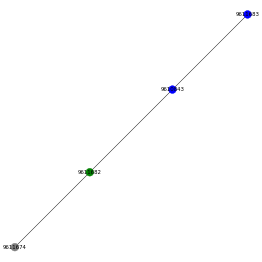

  0%|          | 1/39472 [00:04<46:54:43,  4.28s/it]

DONE


<Figure size 432x288 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

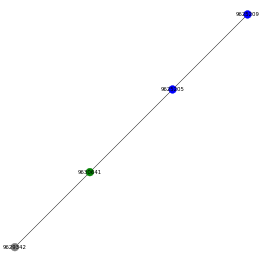

  0%|          | 2/39472 [00:09<53:19:22,  4.86s/it]

DONE


  0%|          | 2/39472 [00:10<58:05:05,  5.30s/it]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

<Figure size 256x256 with 0 Axes>

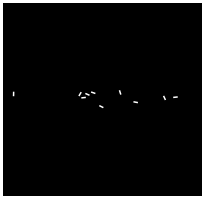

In [19]:
from shapely.geometry.polygon import Polygon, Point

data_path="/home/vikrant/datasets/datasets/argoverse/val/data"
output_dir="../results/"
inn="../../datasets/inn_augmented/"
t_obs=20
dt=0.3
t_obs=20
pred=False
pred_array=None
batch_size = 512
dpi=100
w,h=128,128
res=0.5
paths = glob.glob(os.path.join(data_path, "*.csv"))
color = {
    'polygon': '#e6cf93',
    'polygon-outline': '#e6cf93',
    'centerline': '#fceec7',
    'agent': 'blue',
    'av': 'grey',
    'other': 'grey',
    'outline': 'black'
}
color = {
    'polygon': 'white',
    'polygon-outline': 'white',
    'centerline': 'white',
    'agent': 'white',
    'av': 'white',
    'other': 'white',
    'outline': 'black'
}
import os

from tqdm import tqdm
for idx in tqdm(range(len(paths))):
    path = paths[idx]
    dff = pd.read_csv(path)
    
    city = dff['CITY_NAME'].values[0]    
    
    agent_df = dff[dff['OBJECT_TYPE'] == 'AGENT']
    x_a = agent_df['X'].values
    y_a = agent_df['Y'].values    
    x_a, y_a = denoise(x_a, y_a)
    
#     print(np.arctan2(y_a[-1] - y_a[20], x_a[-1] - x_a[20]), "ABLE")
#     print(np.arctan2(y_a[20] - y_a[0], x_a[20] - x_a[0]), "OK")
#     plt.plot(x_a, y_a, 'green');plt.axis('equal');plt.show()
#     if abs(np.arctan2(y_a[-1] - y_a[20], x_a[-1] - x_a[20]) - np.arctan2(y_a[20] - y_a[0], x_a[20] - x_a[0])) < 0.3:
#         continue
    
    theta_init = np.arctan2(y_a[20] - y_a[0], x_a[20] - x_a[0])    
    x_rotated, y_rotated = rotate(x_a - x_a[0], y_a - y_a[0], -theta_init)    

    arr = np.vstack((x_rotated,y_rotated)).T.flatten()
    np.save("../../datasets/inn_rotated/agents/{}/traj.npy".format(idx), arr)    
    
    av_df = dff[dff['OBJECT_TYPE'] == 'AV']
    x_av = av_df['X'].values
    y_av = av_df['Y'].values
    x_av, y_av = denoise(x_av, y_av)

    others_df = dff[dff['OBJECT_TYPE'] == 'OTHERS']
#     others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
    others_dfs = np.array([v for k, v in others_df.groupby('TIMESTAMP')], dtype=object)
    others_dfs_track = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
    others_dic = {}
    others_dic_track = {}
    track_ids = np.unique(others_df['TRACK_ID'].values)
    timestamps = np.sort((np.unique(others_df['TIMESTAMP'].values)))
    for timestamp in timestamps:
        others_dic[timestamp] = {}
        
    for track_id in track_ids:
        others_dic_track[track_id] = {}        
    
    for other_df in others_dfs:
        for _, row in other_df.iterrows():
            x_other, y_other = row['X'], row['Y']
            x_other, y_other = rotate([x_other - x_a[0]], [y_other - y_a[0]], -theta_init)
            others_dic[row['TIMESTAMP']][row['TRACK_ID']] = np.array([x_other[0], y_other[0]])

    for other_df in others_dfs_track:
        for _, row in other_df.iterrows():
            x_other, y_other = row['X'], row['Y']
            x_other, y_other = rotate([x_other - x_a[0]], [y_other - y_a[0]], -theta_init)
            others_dic_track[row['TRACK_ID']][row['TIMESTAMP']] = np.array([x_other[0], y_other[0]])

    x_o = {}
    y_o = {}
    
    headings = {}
    for timestamp in timestamps:
        tracks = list(others_dic[timestamp].keys())
        lala = plt.figure(figsize=(8,8), dpi=32)        
        x_off = h*2
        y_off = w*2
        points = np.array([[x_a[20] - x_off, y_a[20] + y_off],[x_a[20] + x_off, y_a[20] + y_off], [x_a[20] + x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] + y_off]])        

        x_plot, y_plot = points[:, 0], points[:, 1]
        x_plot, y_plot = x_plot - x_a[0], y_plot - y_a[0]
        x_plot, y_plot = rotate(x_plot, y_plot, -theta_init)
        plt.fill(x_plot, y_plot,'black')
        
        timeind = np.where(timestamps == timestamp)[0][0]
        for track_id in tracks:
            # get heading            
            x_other, y_other = others_dic[timestamp][track_id][0], others_dic[timestamp][track_id][1]
            for k in range(timeind + 1, len(timestamps)):
                if timestamps[k] in list(others_dic_track[track_id].keys()):
                    x_other_next, y_other_next = others_dic_track[track_id][timestamps[k]][0], others_dic_track[track_id][timestamps[k]][1]
                    headings[track_id] = np.arctan2(y_other_next - y_other, x_other_next - x_other)
                    break         
            x_off = 1.5 #0.75
            y_off = 0.5 #1.25

            if headings.get(track_id) == None: headings[track_id] = 0
            theta = headings[track_id]
            points = np.array([[x_other - x_off, y_other + y_off],
                               [x_other + x_off, y_other + y_off], 
                               [x_other + x_off, y_other - y_off],
                               [x_other - x_off, y_other - y_off],
                               [x_other - x_off, y_other + y_off]])
            ww = np.zeros(points.shape)
            ww = points

            A = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            points = points - np.array([x_other, y_other])
            for i,v in enumerate(points): ww[i] = A @ points[i]
            ww[:, 0] += x_other
            ww[:, 1] += y_other
            
            x_plot, y_plot = ww[:, 0], ww[:, 1]
            plt.fill(x_plot, y_plot, "white")
            

        try:
            os.mkdir(inn + "others/{}".format(idx))
        except:
            pass
        plt.axis('equal')  
        plt.xlim([-2,h - 2])
        plt.ylim([-w/2,w/2])            
        plt.axis('off')            
        plt.savefig(inn + "others/{}/{}.png".format(idx, timeind), bbox_inches='tight', pad_inches=0)
        plt.clf()  
    
    # group by timestamp
    dfs = [x for _, x in dff.groupby('TIMESTAMP')]    

    grids_lanes = np.zeros((20, h, w))
    grids_obstacles = np.zeros((20, h, w))
#     grids_centerlines = np.zeros((20, h, w))
    grids_agent = np.zeros((20, h, w))
    
    total_successors = []
    current = []
    das_polygons = []
    das_polygons_mp = []
    das_ids = []

    agent_polygons = []
    
    others_polygons = []
    dic = {}
    G = nx.Graph()

    for indd in range(0, 20):
        lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
        current.append(lane_id)
        successors = avm.get_lane_segment_successor_ids(lane_id, city)
        if successors == None:
            continue
        if dic.get(lane_id) == None:
            dic[lane_id] = 0
            G.add_node(lane_id)         
        for successor in successors:
            if dic.get(successor) == None:
                dic[successor] = 1
                G.add_node(successor)
            G.add_edge(lane_id, successor)
#             if dic.get(lane_id
            total_successors.append(successor)
            successors_2d = avm.get_lane_segment_successor_ids(successor, city)
            if successors_2d == None:
                continue
            for successorr in successors_2d:
                if dic.get(successorr) == None:
                    dic[successorr] = 2
                    G.add_node(successorr)
                G.add_edge(successor, successorr)  
                total_successors.append(successorr)
        polygons = [ avm.get_lane_segment_polygon(successor, city) for successor in successors]
    current = np.unique(np.array(current))
    total_successors = np.unique(np.array(total_successors))    

    color_map = []
    for node in G:
        if dic[node] == 0:
            color_map.append('grey')
        elif dic[node] == 1:
            color_map.append('green')
        else:
            color_map.append('blue')
    nx.draw(G, node_color=color_map,with_labels=True);plt.show();plt.clf()
    for curr in current:
        current_polygon = avm.get_lane_segment_polygon(curr, city)
        das_polygons.append(current_polygon)
        das_polygons_mp.append(avm.get_lane_segment_polygon(curr, city))
        das_ids.append(curr)
    
    for successor in total_successors: 
        polygon = avm.get_lane_segment_polygon(successor, city)
        das_polygons.append(polygon)
        das_polygons_mp.append(avm.get_lane_segment_polygon(successor, city))
        das_ids.append(successor)

        
    lala = plt.figure(figsize=(8,8), dpi=32)        
    x_off = h*2
    y_off = w*2
    points = np.array([[x_a[20] - x_off, y_a[20] + y_off],[x_a[20] + x_off, y_a[20] + y_off], [x_a[20] + x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] + y_off]])        

    x_plot, y_plot = points[:, 0], points[:, 1]
    x_plot, y_plot = x_plot - x_a[0], y_plot - y_a[0]
    x_plot, y_plot = rotate(x_plot, y_plot, -theta_init)
    plt.fill(x_plot, y_plot,'black')
    for polygon in das_polygons: 
        x_plot, y_plot = polygon[:, 0], polygon[:, 1]
        x_plot, y_plot = rotate(x_plot - x_a[0], y_plot - y_a[0], -theta_init)
        plt.fill(x_plot, y_plot, color='white')        

#         plt.fill(x_plot, y_plot,'white')
        try:
            os.mkdir(inn + "das/{}".format(idx))
        except:
            pass
    plt.axis('equal')        
    plt.xlim([-2,h - 2])
    plt.ylim([-w/2,w/2])
    plt.axis('off')            
    plt.savefig(inn + "das/{}/{}.png".format(idx, 0), bbox_inches='tight', pad_inches=0)
    plt.clf()

    das_polygons_mp = np.array(das_polygons_mp)
    x_off = 75
    y_off = 75
    points = np.array([[x_a[20] - x_off, y_a[20] + y_off],[x_a[20] + x_off, y_a[20] + y_off], [x_a[20] + x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] + y_off]])
    
    plt.fill(points[:, 0], points[:, 1],'black')
    plt.clf()
    
    for ind, df in enumerate(dfs):
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
        others_dfs = [x for _, x in others_df.groupby('TRACK_ID')]
        av_df = df[df['OBJECT_TYPE'] == 'AV']

        # agent
        x_traj = agent_df['X'].values
        y_traj = agent_df['Y'].values
        offsets = [x_a[0], y_a[0]] # offsets for other agents
        others_polyon = []
        if ind < len(dfs) - 1:

            lala = plt.figure(figsize=(8,8), dpi=32)
            x_off = h*2
            y_off = w*2
            points = np.array([[x_a[20] - x_off, y_a[20] + y_off],[x_a[20] + x_off, y_a[20] + y_off], [x_a[20] + x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] + y_off]])
            
            x_plot, y_plot = points[:, 0], points[:, 1]
            x_plot, y_plot = x_plot - x_a[0], y_plot - y_a[0]
            x_plot, y_plot = rotate(x_plot, y_plot, -theta_init)
            plt.fill(x_plot, y_plot,'black')            

            x_off = 1.5 #0.75
            y_off = 0.5 #1.25

            theta = np.arctan2((y_rotated[ind + 1] - y_rotated[ind]) , (x_rotated[ind + 1] - x_rotated[ind]))
            points = np.array([[x_rotated[ind] - x_off, y_rotated[ind] + y_off],
                               [x_rotated[ind] + x_off, y_rotated[ind] + y_off], 
                               [x_rotated[ind] + x_off, y_rotated[ind] - y_off],
                               [x_rotated[ind] - x_off, y_rotated[ind] - y_off],
                               [x_rotated[ind] - x_off, y_rotated[ind] + y_off]])
            ww = np.zeros(points.shape)
            ww = points

            A = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            points = points - np.array([x_rotated[ind], y_rotated[ind]])
            for i,v in enumerate(points): ww[i] = A @ points[i]
            ww[:, 0] += x_rotated[ind]
            ww[:, 1] += y_rotated[ind]
            
            x_plot, y_plot = ww[:, 0], ww[:, 1]
            plt.fill(x_plot, y_plot, 'white')
            try:
                os.mkdir(inn + "agents/{}".format(idx))
            except:
                pass
            plt.axis('equal')
            plt.xlim([-2,h - 2])
            plt.ylim([-w/2,w/2])
            plt.axis('off')   
            plt.clf()
#             plt.savefig(inn + "agents/{}/{}.png".format(idx, ind), bbox_inches='tight', pad_inches=0)
#             plt.clf()
#             plt.show()
            
        
    sample = np.zeros((h, w))
    lx = x_a[20] - res*(h/2)
    ly = y_a[20] - res*(w/2)

    print("DONE")
#     break

  0%|          | 0/39472 [00:00<?, ?it/s]

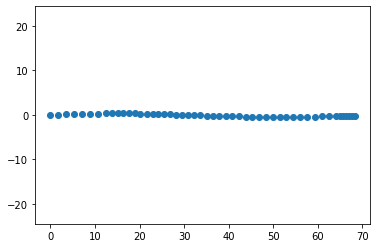

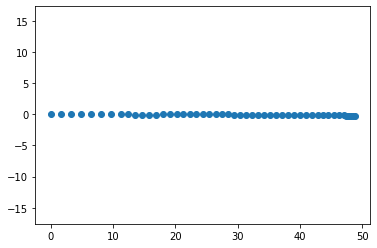

  0%|          | 2/39472 [00:00<1:04:15, 10.24it/s]

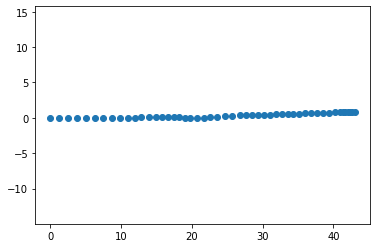

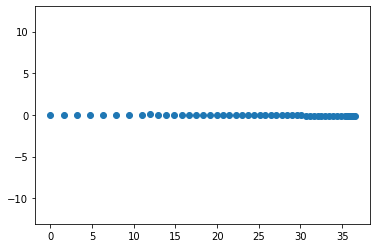

  0%|          | 4/39472 [00:00<1:04:15, 10.24it/s]

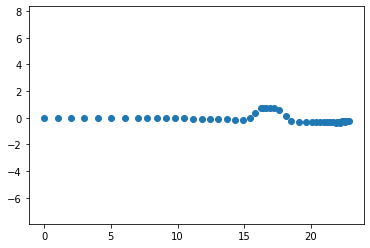

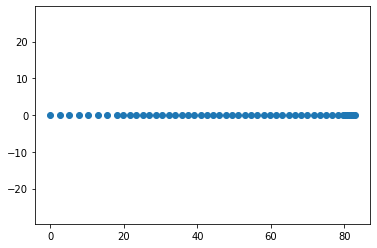

  0%|          | 6/39472 [00:00<1:01:16, 10.73it/s]

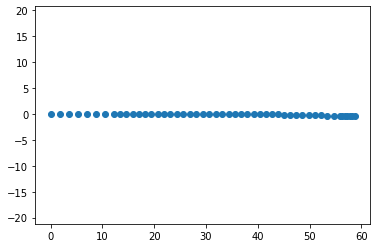

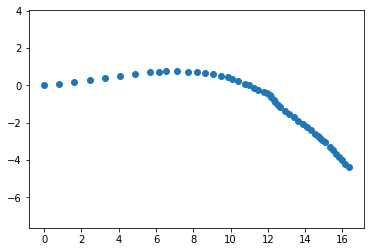

  0%|          | 8/39472 [00:00<1:09:26,  9.47it/s]

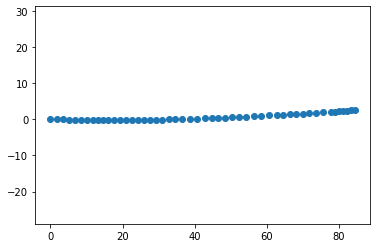

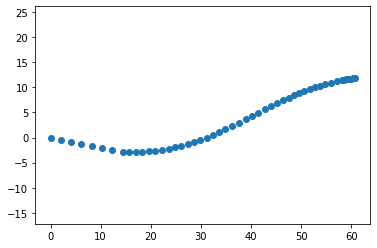

  0%|          | 10/39472 [00:01<1:07:06,  9.80it/s]

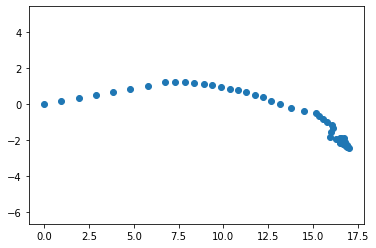

  0%|          | 11/39472 [00:01<1:08:48,  9.56it/s]

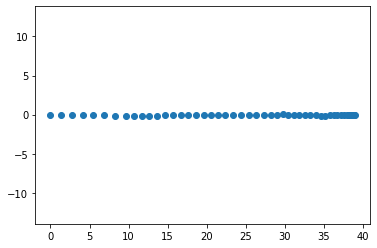

  0%|          | 12/39472 [00:01<1:08:20,  9.62it/s]

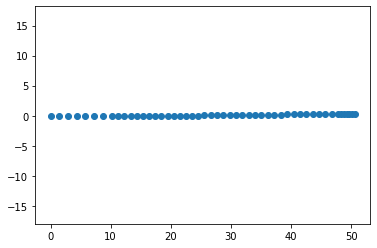

  0%|          | 13/39472 [00:01<1:08:04,  9.66it/s]

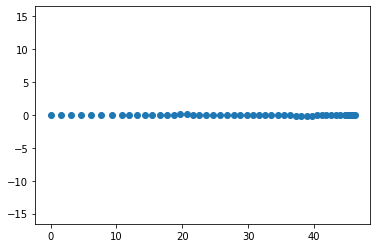

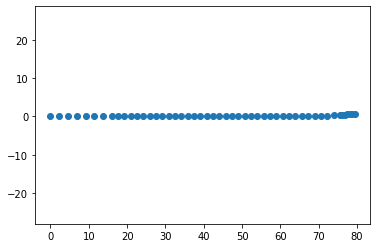

  0%|          | 15/39472 [00:01<1:04:54, 10.13it/s]

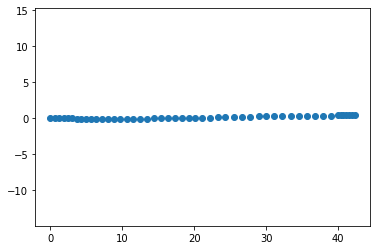

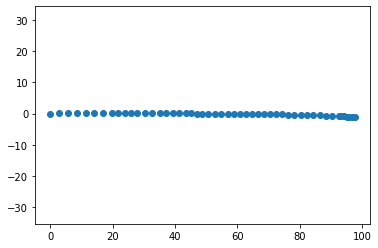

  0%|          | 17/39472 [00:01<1:02:54, 10.45it/s]

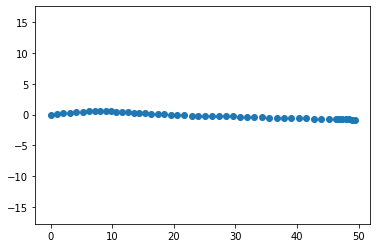

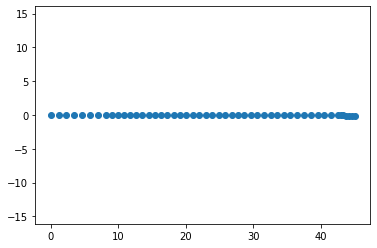

  0%|          | 19/39472 [00:01<1:03:24, 10.37it/s]

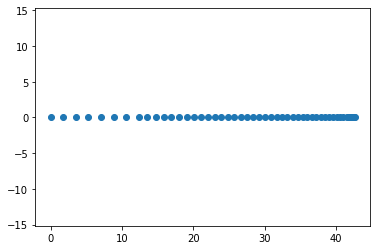

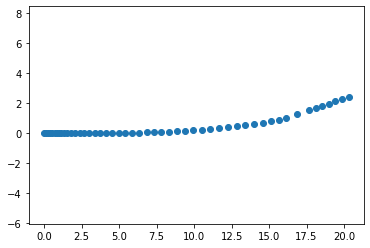

  0%|          | 21/39472 [00:02<1:09:34,  9.45it/s]

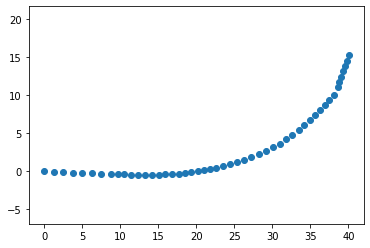

  0%|          | 22/39472 [00:02<1:09:19,  9.48it/s]

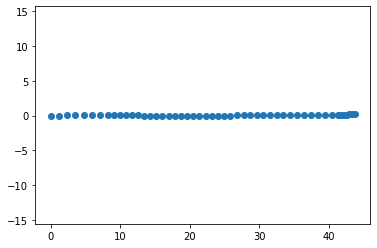

  0%|          | 23/39472 [00:02<1:09:55,  9.40it/s]

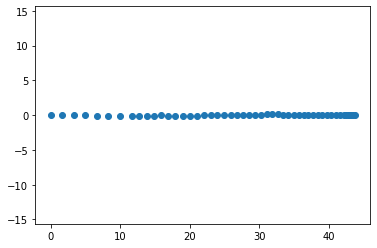

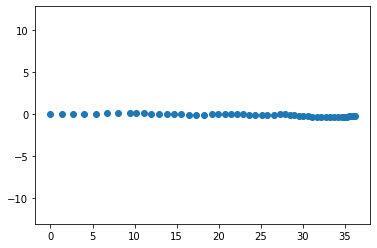

  0%|          | 25/39472 [00:02<1:05:48,  9.99it/s]

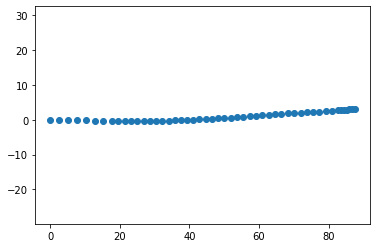

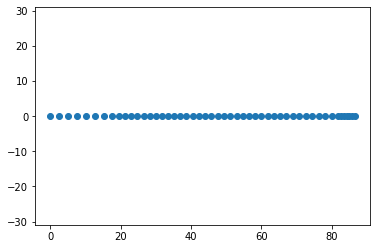

  0%|          | 27/39472 [00:02<1:03:19, 10.38it/s]

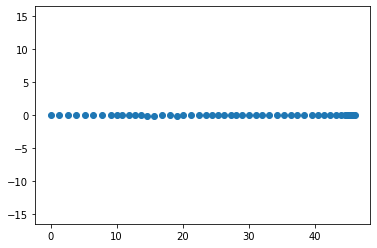

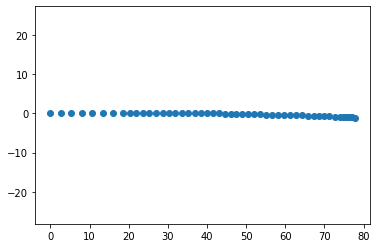

  0%|          | 29/39472 [00:02<1:02:55, 10.45it/s]

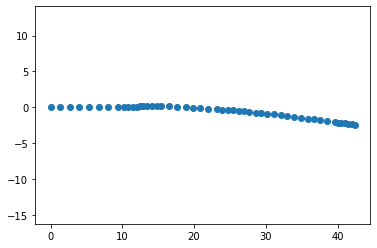

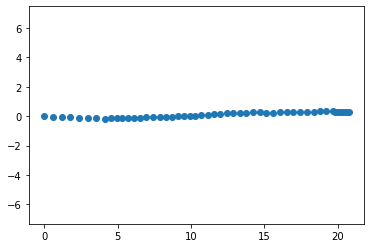

  0%|          | 31/39472 [00:03<1:01:05, 10.76it/s]

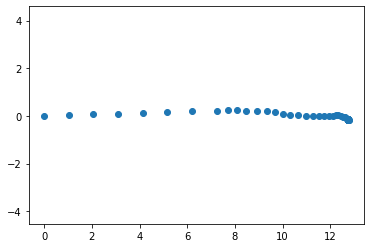

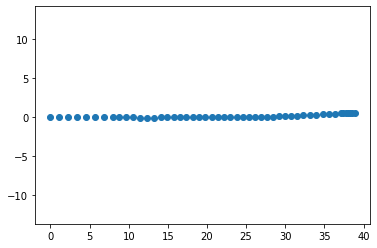

  0%|          | 33/39472 [00:03<1:08:13,  9.63it/s]

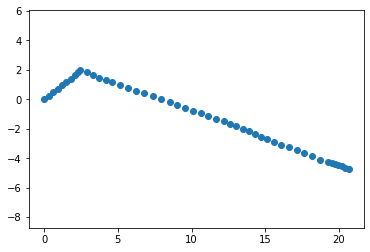

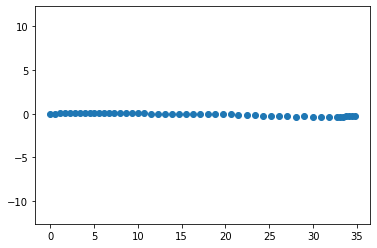

  0%|          | 35/39472 [00:03<1:05:58,  9.96it/s]

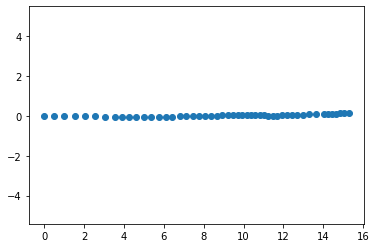

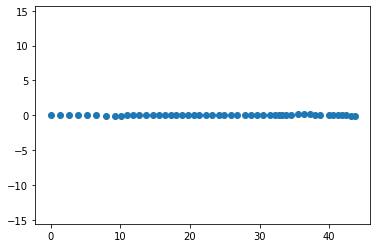

  0%|          | 37/39472 [00:03<1:04:28, 10.19it/s]

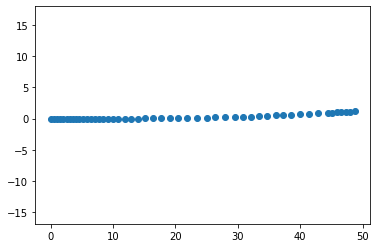

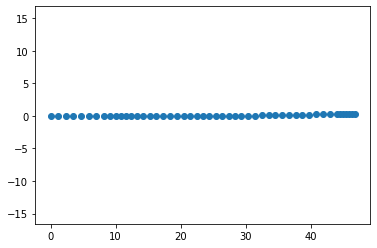

  0%|          | 39/39472 [00:03<1:02:51, 10.45it/s]

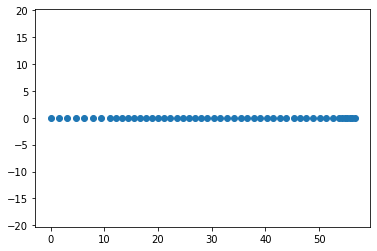

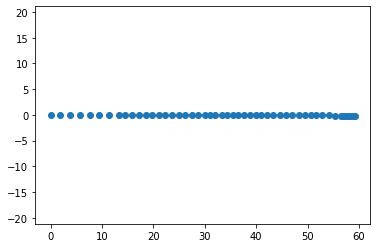

  0%|          | 41/39472 [00:04<1:02:52, 10.45it/s]

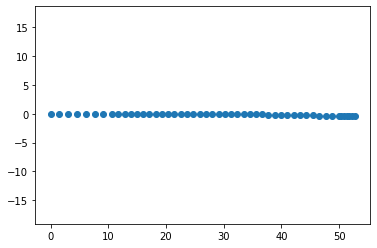

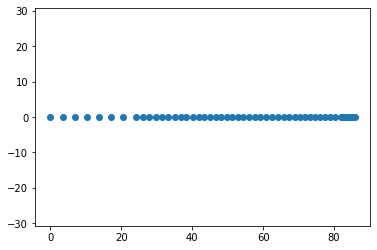

  0%|          | 43/39472 [00:04<1:01:18, 10.72it/s]

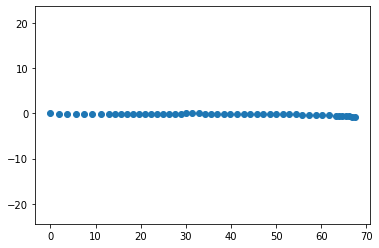

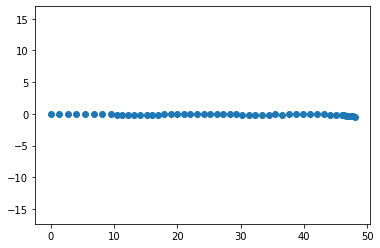

  0%|          | 45/39472 [00:04<1:07:40,  9.71it/s]

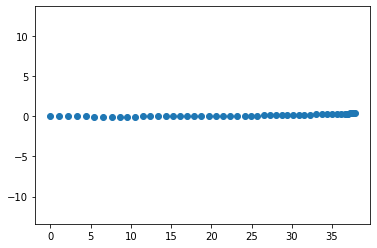

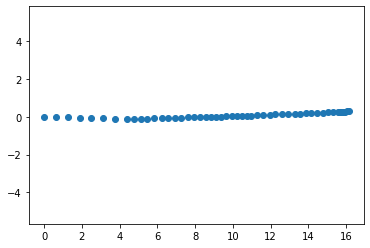

  0%|          | 47/39472 [00:04<1:06:32,  9.88it/s]

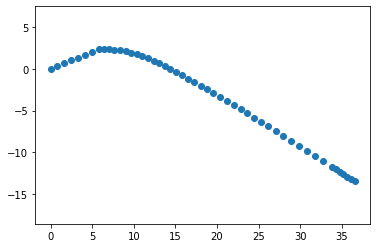

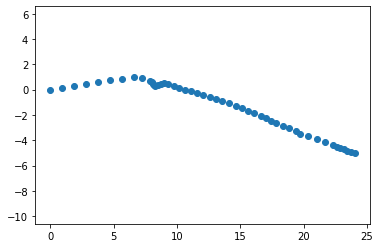

  0%|          | 49/39472 [00:04<1:06:28,  9.88it/s]

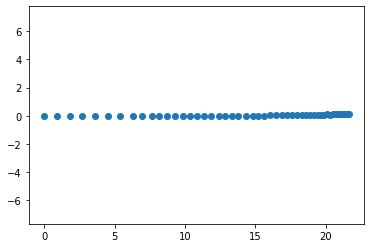

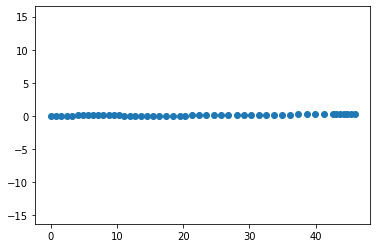

  0%|          | 51/39472 [00:05<1:03:39, 10.32it/s]

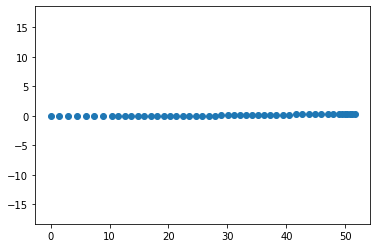

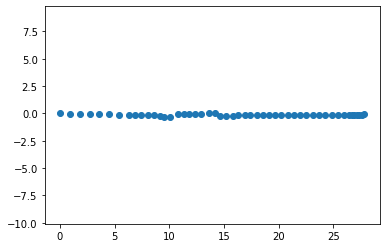

  0%|          | 53/39472 [00:05<1:03:06, 10.41it/s]

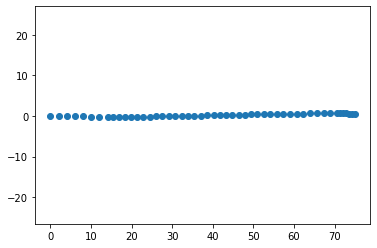

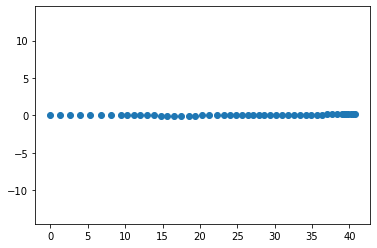

  0%|          | 55/39472 [00:05<1:02:00, 10.60it/s]

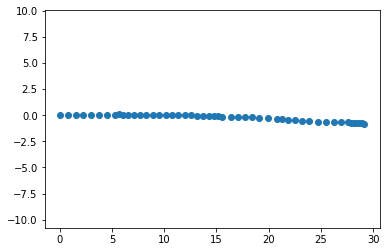

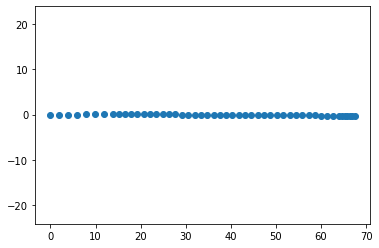

  0%|          | 57/39472 [00:05<1:02:29, 10.51it/s]

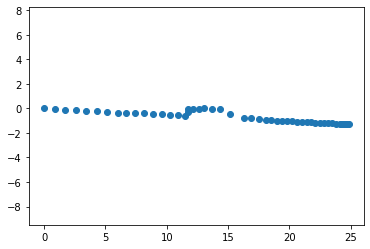

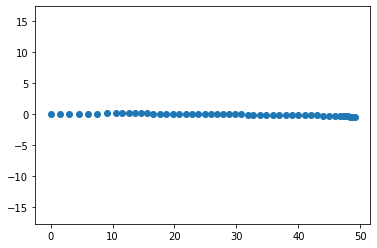

  0%|          | 59/39472 [00:05<1:05:38, 10.01it/s]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [20]:
from shapely.geometry.polygon import Polygon, Point

data_path="/home/vikrant/datasets/datasets/argoverse/val/data"
output_dir="../results/"
inn="../../datasets/inn_augmented/"
t_obs=20
dt=0.3
t_obs=20
pred=False
pred_array=None
batch_size = 512
dpi=100
w,h=128,128
res=0.5
paths = glob.glob(os.path.join(data_path, "*.csv"))
color = {
    'polygon': '#e6cf93',
    'polygon-outline': '#e6cf93',
    'centerline': '#fceec7',
    'agent': 'blue',
    'av': 'grey',
    'other': 'grey',
    'outline': 'black'
}
color = {
    'polygon': 'white',
    'polygon-outline': 'white',
    'centerline': 'white',
    'agent': 'white',
    'av': 'white',
    'other': 'white',
    'outline': 'black'
}
import os
from tqdm import tqdm
for idx in tqdm(range(len(paths))):
    path = paths[idx]
    dff = pd.read_csv(path)
    
    city = dff['CITY_NAME'].values[0]    
    
    agent_df = dff[dff['OBJECT_TYPE'] == 'AGENT']
    x_a = agent_df['X'].values
    y_a = agent_df['Y'].values    
    x_a, y_a = denoise(x_a, y_a)
    
#     print(np.arctan2(y_a[-1] - y_a[20], x_a[-1] - x_a[20]), "ABLE")
#     print(np.arctan2(y_a[20] - y_a[0], x_a[20] - x_a[0]), "OK")
#     plt.plot(x_a, y_a, 'green');plt.axis('equal');plt.show()
#     if abs(np.arctan2(y_a[-1] - y_a[20], x_a[-1] - x_a[20]) - np.arctan2(y_a[20] - y_a[0], x_a[20] - x_a[0])) < 0.3:
#         continue
    
    theta_init = np.arctan2(y_a[20] - y_a[0], x_a[20] - x_a[0])    
    x_rotated, y_rotated = rotate(x_a - x_a[0], y_a - y_a[0], -theta_init)    
    
    av_df = dff[dff['OBJECT_TYPE'] == 'AV']
    x_av = av_df['X'].values
    y_av = av_df['Y'].values
    x_av, y_av = denoise(x_av, y_av)

    others_df = dff[dff['OBJECT_TYPE'] == 'OTHERS']
#     others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
    others_dfs = np.array([v for k, v in others_df.groupby('TIMESTAMP')], dtype=object)
    others_dfs_track = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
    others_dic = {}
    others_dic_track = {}
    track_ids = np.unique(others_df['TRACK_ID'].values)
    timestamps = np.sort((np.unique(others_df['TIMESTAMP'].values)))
    plt.scatter(x_rotated, y_rotated)
    plt.axis('equal')
    plt.show()
    plt.clf()
    arr = np.vstack((x_rotated,y_rotated)).T.flatten()
    np.save("../../inn_rotated/agents/traj.npy".format(idx))

In [12]:
from shapely.geometry.polygon import Polygon, Point

data_path="/home/vikrant/datasets/datasets/argoverse/val/data"
output_dir="../results/"
t_obs=20
dt=0.3
t_obs=20
pred=False
pred_array=None
batch_size = 512
dpi=100
w,h=256,256
res=0.5
paths = glob.glob(os.path.join(data_path, "*.csv"))
color = {
    'polygon': '#e6cf93',
    'polygon-outline': '#e6cf93',
    'centerline': '#fceec7',
    'agent': 'blue',
    'av': 'grey',
    'other': 'grey',
    'outline': 'black'
}
color = {
    'polygon': 'white',
    'polygon-outline': 'white',
    'centerline': 'white',
    'agent': 'white',
    'av': 'white',
    'other': 'white',
    'outline': 'black'
}

from tqdm import tqdm
for idx in tqdm(range(len(paths))):
    path = paths[idx]
    dff = pd.read_csv(path)
    
    city = dff['CITY_NAME'].values[0]    
    
    agent_df = dff[dff['OBJECT_TYPE'] == 'AGENT']
    x_a = agent_df['X'].values
    y_a = agent_df['Y'].values    
    x_a, y_a = denoise(x_a, y_a)    
    
    av_df = dff[dff['OBJECT_TYPE'] == 'AV']
    x_av = av_df['X'].values
    y_av = av_df['Y'].values
    x_av, y_av = denoise(x_av, y_av)
    
    others_df = dff[dff['OBJECT_TYPE'] == 'OTHERS']
    others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
    x_o = {}
    y_o = {}
    
    for other_df in others_dfs:
        x_other, y_other = other_df['X'].values, other_df['Y'].values
        x_other, y_other = denoise(x_other, y_other)
        x_o[other_df['TRACK_ID'].values[0]] = x_other
        y_o[other_df['TRACK_ID'].values[0]] = other_df['Y'].values      
    
    # group by timestamp
    dfs = [x for _, x in dff.groupby('TIMESTAMP')]    

    
    grids_lanes = np.zeros((20, h, w))
    grids_obstacles = np.zeros((20, h, w))
#     grids_centerlines = np.zeros((20, h, w))
    grids_agent = np.zeros((20, h, w))
    
    total_successors = []
    current = []
    das_polygons = []
    das_polygons_mp = []
    das_ids = []

    agent_polygons = []
    
    others_polygons = []
    
    for indd in range(0, 20):
        lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
        current.append(lane_id)
        successors = avm.get_lane_segment_successor_ids(lane_id, city)
        if successors == None:
            continue
        for successor in successors:
            total_successors.append(successor)
            successors_2d = avm.get_lane_segment_successor_ids(successor, city)
            for successorr in successors_2d:
                if successors_2d == None:
                    continue                    
                total_successors.append(successorr)
        polygons = [ avm.get_lane_segment_polygon(successor, city) for successor in successors]
    current = np.unique(np.array(current))
    total_successors = np.unique(np.array(total_successors))    
    for curr in current:
        current_polygon = avm.get_lane_segment_polygon(curr, city)
        das_polygons.append(current_polygon)
        das_polygons_mp.append(avm.get_lane_segment_polygon(curr, city))
        das_ids.append(curr)
#         plt.fill(current_polygon[:, 0], current_polygon[:, 1], color='white', zorder=4)
    for successor in total_successors : 
        polygon = avm.get_lane_segment_polygon(successor, city)
        das_polygons.append(polygon)
        das_polygons_mp.append(avm.get_lane_segment_polygon(successor, city))
        das_ids.append(successor)
#         plt.fill(polygon[:, 0], polygon[:, 1], color='white', zorder=4)
    das_polygons_mp = np.array(das_polygons_mp)
    x_off = 75
    y_off = 75
    points = np.array([[x_a[20] - x_off, y_a[20] + y_off],[x_a[20] + x_off, y_a[20] + y_off], [x_a[20] + x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] + y_off]])

    
    for ind, df in enumerate(dfs):
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
        others_dfs = [x for _, x in others_df.groupby('TRACK_ID')]
        av_df = df[df['OBJECT_TYPE'] == 'AV']

        # agent
        x_traj = agent_df['X'].values
        y_traj = agent_df['Y'].values
        offsets = [x_a[0], y_a[0]] # offsets for other agents
        others_polygon = []
        if ind < len(dfs) - 1:
            x_off = 2 #0.75
            y_off = 10.25 #1.25
            points = np.array([[x_traj[0] - x_off, y_traj + y_off],
                               [x_traj[0] + x_off, y_traj + y_off], 
                               [x_traj[0] + x_off, y_traj - y_off],
                               [x_traj[0] - x_off, y_traj - y_off],
                               [x_traj[0] - x_off, y_traj + y_off]])
            theta = np.arctan2((y_a[ind + 1] - y_a[ind]) , (x_a[ind + 1] - x_a[ind])) - np.pi/2
            ww = np.zeros(points.shape)
            A = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            points = points - np.array([x_traj[0], y_traj[0]])
            for i,v in enumerate(points): ww[i] = A @ points[i]
            ww[:, 0] += x_traj[0]
            ww[:, 1] += y_traj[0]
            agent_polygons.append(Polygon(ww))
            
#         for indoo, other in enumerate(others_dfs):
#             x_traj = other['X'].values
#             y_traj = other['Y'].values
#             indo = other['TRACK_ID'].values[0]
#             if ind < len(dfs) - 1 and ind < len(x_o[indo]) - 1 and ind < len(y_o[indo]) - 1:
#                 x_off = 2
#                 y_off = 2.25
#                 points = np.array([[x_traj[0] - x_off, y_traj + y_off],[x_traj[0] + x_off, y_traj + y_off], [x_traj[0] + x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj + y_off]])
                
#                 theta = np.arctan2((y_o[indo][ind + 1] - y_o[indo][ind]) , (x_o[indo][ind + 1] - x_o[indo][ind])) - np.pi/2
#                 ww = np.zeros(points.shape)
#                 A = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
#                 points = points - np.array([x_traj[0], y_traj[0]])
#                 for i,v in enumerate(points): ww[i] = A @ points[i]
#                 ww[:, 0] += x_traj[0]
#                 ww[:, 1] += y_traj[0]                
#                 others_polyon.append(Polygon(ww))
#         others_polygons.append(others_polyon)
        
    sample = np.zeros((h, w))
    lx = x_a[20] - res*(h/2)
    ly = y_a[20] - res*(w/2)
    
#     seq_lane_props = avm.city_lane_centerlines_dict[city]
#     for lane_id, lane_props in seq_lane_props.items():
#         lane_cl = lane_props.centerline
#         if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
#             lane_centerlines.append(lane_cl)

    
    for i in range(h):
        for j in range(w):
            px = lx + i * res
            py = ly + j * res
            point_xy = Point(px, py)
            flag = 0
            for k in range(len(das_polygons)):
                if Polygon(das_polygons[k]).contains(point_xy):
                    flag = 1
            sample[j,i] = flag
            
            for k in range((20)):
                # get obstacle polygon
#                 for l in range(len(others_polygons[k])):
#                     if others_polygons[k][l].contains(point_xy):
#                         grids_obstacles[k, j, i] = 1
                        
                # get agent polygon
                if agent_polygons[k].contains(point_xy):
                    grids_agent[k, j, i] = 1

    print("DONE")

    for i in range(20):
        plt.imshow(grids_agent[i]);plt.show()
        np.save("../../inn/das/{}.npy".format(i), grids_lanes[i])
        np.save("../../inn/agents/{}.npy".format(i), grids_agent[i])
        np.save("../../inn/others/{}.npy".format(i), grids_obstacles[i])
    print("DONE")
#     break

  0%|          | 0/39472 [00:05<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/39472 [00:00<?, ?it/s]

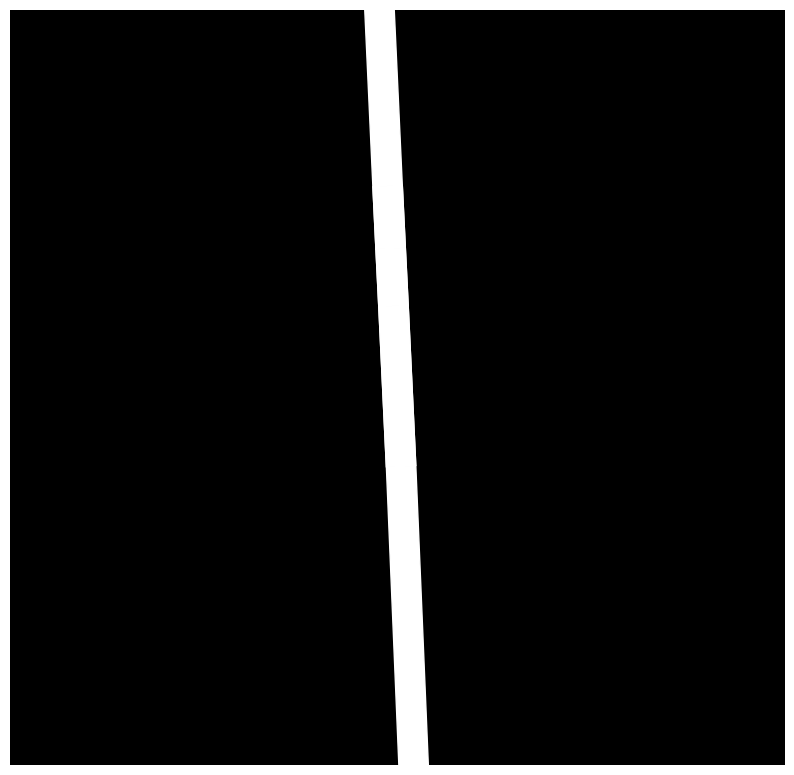

  0%|          | 0/39472 [00:00<?, ?it/s]


<Figure size 432x288 with 0 Axes>

In [24]:
data_path="/datasets/argoverse/val/data"
output_dir="../results/"
t_obs=20
dt=0.3
t_obs=20
pred=False
pred_array=None
batch_size = 512
dpi=100
w,h=200,200
paths = glob.glob(os.path.join(data_path, "*.csv"))
color = {
    'polygon': '#e6cf93',
    'polygon-outline': '#e6cf93',
    'centerline': '#fceec7',
    'agent': 'blue',
    'av': 'grey',
    'other': 'grey',
    'outline': 'black'
}
color = {
    'polygon': 'white',
    'polygon-outline': 'white',
    'centerline': 'white',
    'agent': 'white',
    'av': 'white',
    'other': 'white',
    'outline': 'black'
}

from tqdm import tqdm
for idx in tqdm(range(len(paths))):
    path = paths[idx]
    dff = pd.read_csv(path)
    
    city = dff['CITY_NAME'].values[0]    
    
    agent_df = dff[dff['OBJECT_TYPE'] == 'AGENT']
    x_a = agent_df['X'].values
    y_a = agent_df['Y'].values    
    x_a, y_a = denoise(x_a, y_a)    
    
    av_df = dff[dff['OBJECT_TYPE'] == 'AV']
    x_av = av_df['X'].values
    y_av = av_df['Y'].values
    x_av, y_av = denoise(x_av, y_av)
    
    others_df = dff[dff['OBJECT_TYPE'] == 'OTHERS']
    others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
    x_o = {}
    y_o = {}
    
    for other_df in others_dfs:
        x_other, y_other = other_df['X'].values, other_df['Y'].values
        x_other, y_other = denoise(x_other, y_other)
        x_o[other_df['TRACK_ID'].values[0]] = x_other
        y_o[other_df['TRACK_ID'].values[0]] = other_df['Y'].values      
    
    # group by timestamp
    dfs = [x for _, x in dff.groupby('TIMESTAMP')]    

    total_successors = []
    current = []
    das_polygons = []
    das_ids = []
    for indd in range(0, 20):
        lane_id = avm.get_nearest_centerline(np.array([x_a[indd],y_a[indd]]), city_name=city)[0].id
        current.append(lane_id)
        successors = avm.get_lane_segment_successor_ids(lane_id, city)
        if successors == None:
            continue
        for successor in successors:
            total_successors.append(successor)
            successors_2d = avm.get_lane_segment_successor_ids(successor, city)
            for successorr in successors_2d:
                if successors_2d == None:
                    continue                    
                total_successors.append(successorr)
        polygons = [ avm.get_lane_segment_polygon(successor, city) for successor in successors]
    current = np.unique(np.array(current))
    total_successors = np.unique(np.array(total_successors))    
    for curr in current:
        current_polygon = avm.get_lane_segment_polygon(curr, city)
        das_polygons.append(current_polygon)
        das_ids.append(curr)
#         plt.fill(current_polygon[:, 0], current_polygon[:, 1], color='white', zorder=4)
    for successor in total_successors : 
        polygon = avm.get_lane_segment_polygon(successor, city)
        das_polygons.append(polygon)
        das_ids.append(successor)
#         plt.fill(polygon[:, 0], polygon[:, 1], color='white', zorder=4)
    
    x_off = 75
    y_off = 75
    points = np.array([[x_a[20] - x_off, y_a[20] + y_off],[x_a[20] + x_off, y_a[20] + y_off], [x_a[20] + x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] - y_off],[x_a[20] - x_off, y_a[20] + y_off]])
    for ind, df in enumerate(dfs):
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
        others_dfs = [x for _, x in others_df.groupby('TRACK_ID')]
        av_df = df[df['OBJECT_TYPE'] == 'AV']

        # agent
        x_traj = agent_df['X'].values
        y_traj = agent_df['Y'].values
        offsets = [x_a[0], y_a[0]] # offsets for other agents
        fig = plt.figure(figsize=(10, 10), dpi=dpi)
#         plt.axis('off')
#         plt.xlim([x_a[20] - 50, x_a[20] + 50])
#         plt.ylim([y_a[20] - 50, y_a[20] + 50]) 
#         plt.fill(points[:, 0], points[:, 1], color=color['outline'], zorder=0)
#         plt.show()
        
        
        for curr in das_ids:
            current_polygon = avm.get_lane_segment_polygon(curr, city)
            plt.fill(current_polygon[:, 0], current_polygon[:, 1], color='white', zorder=4)
        plt.axis('off')
        plt.xlim([x_a[20] - 50, x_a[20] + 50])
        plt.ylim([y_a[20] - 50, y_a[20] + 50]) 
        plt.fill(points[:, 0], points[:, 1], color=color['outline'], zorder=0)
        plt.show()
        plt.clf()

        
        '''
        if ind < len(dfs) - 1:
            x_off = 0.75
            y_off = 1.25
            points = np.array([[x_traj[0] - x_off, y_traj + y_off],[x_traj[0] + x_off, y_traj + y_off], [x_traj[0] + x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj + y_off]])
            theta = np.arctan2((y_a[ind + 1] - y_a[ind]) , (x_a[ind + 1] - x_a[ind])) - np.pi/2
            w = np.zeros(points.shape)
            A = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            points = points - np.array([x_traj[0], y_traj[0]])
            for i,v in enumerate(points): w[i] = A @ points[i]
            plt.fill(w[:, 0] + x_traj[0], w[:, 1] + y_traj[0], color=color['agent'], zorder=5)
        plt.scatter(x_traj[0], y_traj[0], color=color['agent'], label='end observed', zorder=5)

        # av
        x_traj = av_df['X'].values
        y_traj = av_df['Y'].values
        x_max, y_max = np.max(x_traj), np.max(y_traj)
        x_min, y_min = np.min(x_traj), np.min(y_traj)

        if ind < len(dfs) - 1:
            x_off = 0.75
            y_off = 1.25
            points = np.array([[x_traj[0] - x_off, y_traj + y_off],[x_traj[0] + x_off, y_traj + y_off], [x_traj[0] + x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj + y_off]])
            theta = np.arctan2((y_av[ind + 1] - y_av[ind]) , (x_av[ind + 1] - x_av[ind])) - np.pi/2
            w = np.zeros(points.shape)
            A = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
            points = points - np.array([x_traj[0], y_traj[0]])
            for i,v in enumerate(points): w[i] = A @ points[i]
            plt.fill(w[:, 0] + x_traj[0], w[:, 1] + y_traj[0], color=color['av'], zorder=4)
        
        plt.scatter(x_traj[-1], y_traj[-1], color=color['av'], zorder=4)

        # others
        for indoo, other in enumerate(others_dfs):
            x_traj = other['X'].values
            y_traj = other['Y'].values
            indo = other['TRACK_ID'].values[0]
            if ind < len(dfs) - 1 and ind < len(x_o[indo]) - 1 and ind < len(y_o[indo]) - 1:
                x_off = 0.75
                y_off = 1.25
                points = np.array([[x_traj[0] - x_off, y_traj + y_off],[x_traj[0] + x_off, y_traj + y_off], [x_traj[0] + x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj - y_off],[x_traj[0] - x_off, y_traj + y_off]])
                
                theta = np.arctan2((y_o[indo][ind + 1] - y_o[indo][ind]) , (x_o[indo][ind + 1] - x_o[indo][ind])) - np.pi/2
                w = np.zeros(points.shape)
                A = np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
                points = points - np.array([x_traj[0], y_traj[0]])
                for i,v in enumerate(points): w[i] = A @ points[i]
                plt.fill(w[:, 0] + x_traj[0], w[:, 1] + y_traj[0], color=color['other'], zorder=4)
            

        # centerlines
        lane_centerlines = []    
        # Get lane centerlines which lie within the range of trajectories
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        gt_x = agent_df['X'].values
        gt_y = agent_df['Y'].values

        x_max, y_max = np.max(x_a) + 50, np.max(y_a) + 50
        x_min, y_min = np.min(x_a) - 50, np.min(y_a) - 50

        avm = ArgoverseMap()
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            plt.fill(arr[:, 0], arr[:, 1], color=color['polygon'],zorder=0)

        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            plt.plot(arr[:, 0], arr[:, 1], color=color['polygon-outline'],zorder=1)

        seq_lane_props = avm.city_lane_centerlines_dict[city]
        for lane_id, lane_props in seq_lane_props.items():
            lane_cl = lane_props.centerline
            if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
                lane_centerlines.append(lane_cl)

        for lane_cl in lane_centerlines:
            plt.plot(lane_cl[:, 0], lane_cl[:, 1], color=color['centerline'], alpha=1, linewidth=1, zorder=2)

#         plt.legend()
        import os
        try:
            os.mkdir('../results/{}'.format(idx))
        except:
            pass
#         plt.set_facecolor('red')
#         fig.canvas.draw()
#         data_image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
#         data_image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#         print(data_image.shape)

        # Probability as a function of distance from the center derived
        # from a gaussian distribution with mean = 0 and stdv = 1
#         scaledGaussian = lambda x : exp(-(1/2)*(x**2))

        # Convert Grayscale to HeatMap Using Opencv
#         plt.savefig('../results/{}/{}.png'.format(idx,ind), dpi=dpi, bbox_inches='tight')
#         plt.imshow(isotropicGrayscaleImage, cmap='hot', interpolation='nearest', zorder=7, alpha=0.7)
        plt.show()
        '''
        break
#         plt.show()
#         plt.clf()
#     np.save("../results/offsets/{}.npy".format(idx), np.array([x_a[49], y_a[49]]))
    break

In [ ]:
import cv2
from PIL import Image
path = '../results/0/0.png'
img = cv2.imread(path)
image = Image.open('../results/0/0.png')
print(np.asarray(image).shape)
print(img.shape)

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.imshow(data, interpolation='nearest')

In [ ]:
def vis_trajectories(data_path, output_dir="results/", dt = 0.3, t_obs=20, pred=False, pred_array=None, batch_size = 512):
    paths = glob.glob(os.path.join(data_path, "*.csv"))
    for idx in range(len(paths)):
        path = paths[idx]
        df = pd.read_csv(path)
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
        others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
        av_df = df[df['OBJECT_TYPE'] == 'AV']
        city = df['CITY_NAME'].values[0]

        # agent
        x_traj = agent_df['X'].values
        y_traj = agent_df['Y'].values
        x_a, y_a = x_traj, y_traj
        x_max, y_max = np.max(x_traj), np.max(y_traj)
        x_min, y_min = np.min(x_traj), np.min(y_traj)

        offsets = [x_traj[0], y_traj[0]] # offsets for other agents
    #         x_traj, y_traj, v_x, v_y, psi, psi_dot, psi_traj, psidot_traj, theta_agent = transform(x_traj, y_traj)
        plt.figure(figsize=(15,15))

        plt.plot(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='observed')
        plt.scatter(x_traj[t_obs], y_traj[t_obs], color='blue', label='end observed')
        plt.plot(x_traj[t_obs:], y_traj[t_obs:], color='orange', label='gt')
        plt.scatter(x_traj[-1], y_traj[-1], color='orange', label='gt end point')
        if pred:
            x_traj, y_traj, v_x, v_y, psi, psi_dot, psi_traj, psidot_traj, theta_agent = transform(x_traj, y_traj)
            pred_x = pred_array[idx][:, 0]
            pred_y = pred_array[idx][:, 1]
            pred_x, pred_y = rotate(pred_x, pred_y, -theta)
            pred_x += offsets[0]
            pred_y += offsets[1]
            plt.plot(pred_x, pred_y, color='orange', label='predicted')
            plt.scatter(pred_x[-1], pred_y[-1], color='orange', label='predicted goal point')    

        # av
        x_traj = av_df['X'].values
        y_traj = av_df['Y'].values
        x_max, y_max = np.max(x_traj), np.max(y_traj)
        x_min, y_min = np.min(x_traj), np.min(y_traj)

        plt.plot(x_traj, y_traj, color='red', label='AV')
        plt.scatter(x_traj[-1], y_traj[-1], color='red')

        # others
        for other in others_dfs:
            x_traj = other['X'].values
            y_traj = other['Y'].values
            x_max, y_max = np.max(x_traj), np.max(y_traj)
            x_min, y_min = np.min(x_traj), np.min(y_traj)

    #             x_traj, y_traj, v_x, v_y, psi, psi_dot, psi_traj, psidot_traj, theta_others = transform(x_traj, y_traj, theta = theta_agent, offsets = offsets)
            plt.plot(x_traj, y_traj, color='grey')
            plt.scatter(x_traj[-1], y_traj[-1], color='grey')

        # centerlines
        lane_centerlines = []    
        # Get lane centerlines which lie within the range of trajectories
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        gt_x = agent_df['X'].values
        gt_y = agent_df['Y'].values

        x_max, y_max = np.max(gt_x) + 30, np.max(gt_y) + 30
        x_min, y_min = np.min(gt_x) - 30, np.min(gt_y) - 30

        print(x_max, x_min)
        print(y_max, y_min)
        avm = ArgoverseMap()
        for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
            plt.plot(arr[:, 0], arr[:, 1], color='black')

        seq_lane_props = avm.city_lane_centerlines_dict[city]
        for lane_id, lane_props in seq_lane_props.items():
            lane_cl = lane_props.centerline
            if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
                lane_centerlines.append(lane_cl)

        for lane_cl in lane_centerlines:
            plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)

        plt.legend()
        plt.xlim([x_a[20] - 50, x_a[20] + 50])
        plt.ylim([y_a[20] - 50, y_a[20] + 50])
        plt.show()
        break

In [ ]:
# # predictions = np.load('../prediction.npy', allow_pickle=True)
vis_trajectories(data_path = "/datasets/argoverse/val/data", output_dir="../results/", t_obs=20)

In [ ]:
import pandas as pd
data_ = pd.read_pickle('/datasets/argoverse/forecasting_features_val.pkl')
features = data_["FEATURES"].values
features[0].shape

In [ ]:
for i in range(num):
    city = features[i][0][5]
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    
    gt_x = features[i][:, 3]
    gt_y = features[i][:, 4]
    
    x_max, y_max = np.max(gt_x) + 50, np.max(gt_y) + 50
    x_min, y_min = np.min(gt_x) - 50, np.min(gt_y) - 50
    print(x_max, x_min)
    print(y_max, y_min)
    
    lane_centerlines = []    
    # Get lane centerlines which lie within the range of trajectories
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    
    plt.plot(gt_x[:20], gt_y[:20], color='blue', label='observed')
    plt.plot(gt_x[20:], gt_y[20:], color='orange', label='gt')
#     plt.plot(pred_x[20:], pred_y[20:], color='red', label='predicted')
    plt.legend()
    plt.show()
    

In [ ]:
for i in range(num):
    city = features[i][0][5]
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    
    gt_x = features[i][:, 3]
    gt_y = features[i][:, 4]
    
    x_max, y_max = np.max(gt_x) + 50, np.max(gt_y) + 50
    x_min, y_min = np.min(gt_x) - 50, np.min(gt_y) - 50
    print(x_max, x_min)
    print(y_max, y_min)
    
    lane_centerlines = []
    plt.figure(figsize=(10, 10))
    # Get lane centerlines which lie within the range of trajectories
    for arr in avm.find_local_lane_polygons([x_min, x_max, y_min, y_max], city):
        plt.plot(arr[:, 0], arr[:, 1], color='black')
        plt.xlim([x_min, x_max])
        plt.ylim([y_min, y_max])
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)
    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    plt.plot(gt_x[:20], gt_y[:20], color='blue', label='observed')
    plt.plot(gt_x[20:], gt_y[20:], color='orange', label='gt')
#     plt.plot(pred_x[20:], pred_y[20:], color='red', label='predicted')
    plt.legend()
    plt.show()
    plt.clf()